# Image Classification(Sign Language Digits) by ResNets 

## Some Notes about ResNets

### Math Representation
$$a^{[l+2]} = g(z^{[l + 2]} + a^{[l]}) = g(w^{[l + 2]} \times a^{[l+1]} + a^{[l]}) $$

### About Deep NN
* Deep NN can represent very conplex functions
* But, varishing gradient is a problem when training

### Benefits of ResNet
* Use skip-connection helps the gradient to backpropogate 
* The skip-connection makes it easy to learn an identity mapping between the input and the output within the ResNet block

## Import Packages

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as keras
from progressbar import progressbar
from tensorflow.keras.models import Model, load_model
import h5py

## Load Data

In [21]:
def load_data():
    trainset_path = 'datasets/Sign_Language_Digits/train_signs.h5'
    testset_path = 'datasets/Sign_Language_Digits/test_signs.h5'

    train_dataset = h5py.File(trainset_path, "r")
    x_train = np.array(train_dataset["train_set_x"][:])    
    y_train = np.array(train_dataset["train_set_y"][:])  

    test_dataset = h5py.File(testset_path, "r")
    x_test = np.array(test_dataset["test_set_x"][:])
    y_test = np.array(test_dataset["test_set_y"][:])  
    classes = np.array(test_dataset["list_classes"][:])
    
    return x_train, y_train, x_test, y_test, classes


In [22]:
x_train, y_train, x_test, y_test, classes = load_data()
num_classes = len(classes)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Classes: {classes}")
print(f"Number of Classes: {num_classes}")

x_train shape: (1080, 64, 64, 3)
y_train shape: (1080,)
x_test shape: (120, 64, 64, 3)
y_test shape: (120,)
Classes: [0 1 2 3 4 5]
Number of Classes: 6


In [23]:
x_cv = x_train[0:120] ; y_cv = y_train[0:120]
x_train = x_train[120:] ; y_train = y_train[120:]
_, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = x_train.shape
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_cv shape: {x_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (960, 64, 64, 3)
y_train shape: (960,)
x_cv shape: (120, 64, 64, 3)
y_cv shape: (120,)
x_test shape: (120, 64, 64, 3)
y_test shape: (120,)


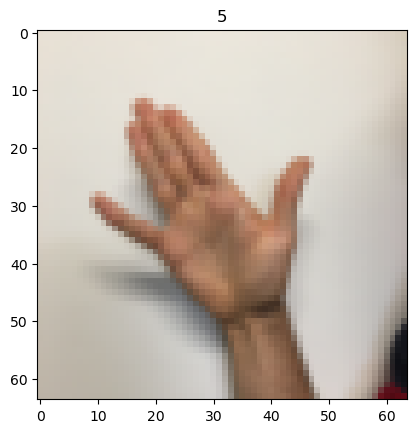

In [24]:
def show_image(image, label):
    plt.imshow(np.uint8(image))
    plt.title(label)

show_image(x_train[0], y_train[0])

## Build Model

### Identity Block
![](images/ResNets/id_block.png)


#### First component of main path: 
* $F_1$ filters 
* shape (1,1)
* stride of (1,1) 
* padding is "valid". 

#### Second component of main path:
* $F_2$ filters 
* shape $(f,f)$ 
* stride of (1,1)
* padding is "same"

#### Third component of main path:
* $F_3$ filters
* shape (1,1) 
* stride of (1,1)
* padding is "valid"



In [25]:
def identity_block(X, f, filters, training=True, 
                   initializer=keras.initializers.random_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    f -- integer, specifying the shape of the middle CONV's window 
         for the main path
    
    filters -- python list of integers, defining the number of filters
               in the CONV layers of the main path
               
    training -- True: Behave in training mode
                False: Behave in inference mode
                
    initializer -- to set up the initial weights of a layer.
                   Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = tfl.Conv2D(filters = F1, 
               kernel_size = (1,1), 
               strides = (1,1), 
               padding = 'valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    X = tfl.Activation('relu')(X)
    
    ## Second component of main path
    X = tfl.Conv2D(filters = F2, 
               kernel_size = (f,f),
               strides = (1, 1),
               padding = 'same',
               kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    X = tfl.Activation('relu')(X) 

    ## Third component of main path
    X = tfl.Conv2D(filters = F3, 
               kernel_size = (1,1),
               strides = (1, 1),
               padding = 'valid',
               kernel_initializer = initializer(seed=0))(X) 
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    
    # Add shortcut
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)

    return X

### Convolution Block
![](images/ResNets/conv_block.png)

#### First component of main path:
* $F_1$ filters
* shape (1,1)
* stride of (s,s)
* padding is "valid"

#### Second component of main path:
* $F_2$ filters 
* shape (f,f) 
* stride of (1,1)
* padding is "same"

#### Third component of main path:
* $F_3$ filters 
* shape (1,1) 
* stride of (1,1)
* padding is "valid"

#### Shortcut path:
* $F_3$ filters
* shape (1,1) 
* stride of (s,s)
* padding is "valid"


In [26]:
def convolutional_block(X, f, filters, s = 2, training=True, 
                        initializer=keras.initializers.glorot_uniform):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    f -- integer, specifying the shape of the middle CONV's window
         for the main path
    
    filters -- python list of integers, defining the number of filters 
               in the CONV layers of the main path
    
    s -- Integer, specifying the stride to be used
    
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    initializer -- to set up the initial weights of a layer. 
                   Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # main path first component
    X = tfl.Conv2D(filters = F1, 
               kernel_size = 1, 
               strides = (s, s), 
               padding='valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training)
    X = tfl.Activation('relu')(X)

    # main path second component
    X = tfl.Conv2D(filters = F2, 
               kernel_size = f, 
               strides = (1,1), 
               padding = 'same', 
               kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X , training=training)
    X = tfl.Activation('relu')(X) 

    
    # main path third component
    X = tfl.Conv2D(filters = F3, 
               kernel_size = 1, 
               strides = (1,1), 
               padding = 'valid', 
               kernel_initializer = initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X, training=training) 
    
    # short cut path
    X_shortcut = tfl.Conv2D(filters = F3, 
                        kernel_size = 1, 
                        strides = (s,s), 
                        padding = 'valid', 
                        kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = tfl.BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    X = tfl.Add()([X, X_shortcut])
    X = tfl.Activation('relu')(X)
    
    return X

### ResNet
![](images/ResNets/resnet.png)

In [27]:
def ResNet50(input_shape, num_classes):
    '''
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    '''
    
    X_input = keras.Input(input_shape)

    X = tfl.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(filters = 64, 
                   kernel_size = (7, 7), 
                   strides = (2, 2), 
                   kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    
    # Average pooling
    X = tfl.AveragePooling2D()(X)
    
    # output layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(num_classes, 
              activation='softmax', 
              kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [28]:
resnet50 = ResNet50(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
                    num_classes = num_classes)

In [29]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_53 (BatchN  (None, 32, 32, 64)  256         ['conv2d_53[0][0]']        

                                                                                                  
 conv2d_63 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_57[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_63[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 15, 15, 256)  0           ['batch_normalization_63[0][0]', 
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 15, 15, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 8, 8, 512)    0           ['batch_normalization_73[0][0]', 
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 8, 8, 512)    0           ['add_21[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 128)   512         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_77 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_77[0][0]']          
                                                                                                  
 batch_normalization_85 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
          

 activation_87 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_94[0][0]'] 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_87[0][0]']          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_95[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_28 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_95[0][0]', 
                                                                  'activation_85[0][0]']          
                                                                                                  
 activatio

                                                                                                  
 add_31 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_105[0][0]',
                                                                  'activation_94[0][0]']          
                                                                                                  
 activation_97 (Activation)     (None, 2, 2, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_97[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
          

In [30]:
resnet50.compile(optimizer = 'adam', 
                 loss = 'sparse_categorical_crossentropy', 
                 metrics = ["accuracy"])

resnet50.fit(x_train, 
             y_train,
             epochs = 10, 
             validation_data = (x_cv, y_cv))

Epoch 1/10


2023-07-28 03:00:19.068346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-28 03:00:19.951483: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


30/30 [==============================] - ETA: 0s - loss: 1.9952 - accuracy: 0.4563

2023-07-28 03:00:27.937922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 16s 217ms/step - loss: 1.9952 - accuracy: 0.4563 - val_loss: 1.8922 - val_accuracy: 0.4500
Epoch 2/10
30/30 [==============================] - 4s 126ms/step - loss: 0.7040 - accuracy: 0.7615 - val_loss: 0.8756 - val_accuracy: 0.7167
Epoch 3/10
30/30 [==============================] - 4s 129ms/step - loss: 0.3582 - accuracy: 0.8906 - val_loss: 1.4453 - val_accuracy: 0.6667
Epoch 4/10
30/30 [==============================] - 4s 130ms/step - loss: 0.2701 - accuracy: 0.9083 - val_loss: 0.6928 - val_accuracy: 0.7750
Epoch 5/10
30/30 [==============================] - 4s 127ms/step - loss: 0.2734 - accuracy: 0.9083 - val_loss: 0.8130 - val_accuracy: 0.7750
Epoch 6/10
30/30 [==============================] - 4s 131ms/step - loss: 0.2877 - accuracy: 0.9240 - val_loss: 0.6968 - val_accuracy: 0.8250
Epoch 7/10
30/30 [==============================] - 4s 128ms/step - loss: 0.2449 - accuracy: 0.9271 - val_loss: 0.6631 - val_accuracy: 0.7917
Epoch 8/10
30/30

<Axes: >

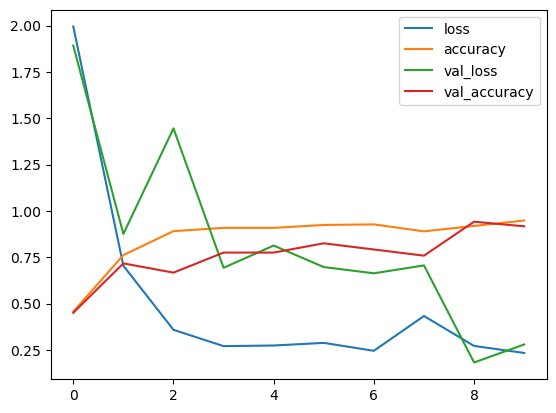

In [31]:
model_loss = pd.DataFrame(resnet50.history.history)
model_loss.plot()

In [32]:
resnet50.evaluate(x_test, y_test)

4/4 [==============================] - 0s 41ms/step - loss: 0.3636 - accuracy: 0.9083


[0.3635804355144501, 0.9083333611488342]

1/1 [==============================] - 0s 47ms/step


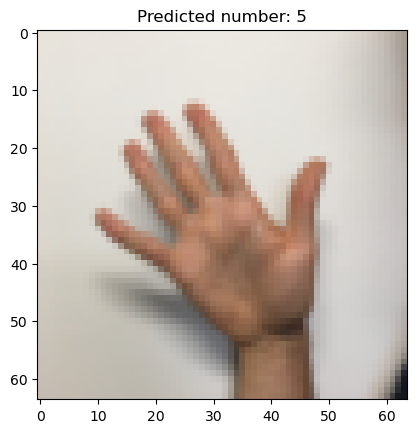

In [36]:
def predict_number(image, model):
    image_batch = np.array([image])
    plt.imshow(np.uint8(image_batch[0]))
    predicted_number = np.argmax(model.predict(image_batch))
    plt.title("Predicted number: " + str(predicted_number))

predict_number(x_test[3], resnet50)
    